<a href="https://colab.research.google.com/github/konkuk-gaegul/3rd-Team-Project/blob/main/TensorFlow_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 웰시코기 담당


|이미지 세트|비만|정상|총 합|
|------|---|---|----|
|1차 수집|579|408|987|
|2차 수집|617|624|1241|


# 웰시코기 1차 이미지 수집
- 웹 크롤링을 활용하여 약 6,000여 장 확보
- 수기로 학습에 사용할 수 있는 이미지 1,000장 선정
- 비만:정상 = 4:6 비율로 이미지 세트 분류
    - 기존 목표 5:5 수집의 한계 존재
        - 일반적으로 비만견 개체가 적은 편
        - 크롤링 이미지에 중복된 자료 존재

# 지도학습
- Keras CNN으로 학습
    - 강의 교안과 딥러닝 책에서 배운 신경 네트워크와 parameter 사용
    - 이미지 전처리
        - 스케일링과 이미지 증식
        - 이미지 증식은 훈련용 자료에만 적용!
- 정상 579장, 비만 408장
- 구글 코랩 GPU 활용하여 학습
- train / validation / test : 50% / 20% / 30% 비율로 세트 분할

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import os, sys, json, cv2, shutil

import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
import pandas as pd

from PIL import Image
from sklearn import datasets

In [ ]:
!pwd

/home/lab13/웰시코기/set_2


In [ ]:
%cd dog_pic/웰시코기

/home/lab13/dog_pic/웰시코기


In [ ]:
%cd ..

/home/lab13


In [ ]:
!dir

웰시코기_set_1	웰시코기_set_1.zip  웰시코기_set_2  웰시코기_set_2.zip


# 웰시코기 학습 1
- 기본 이미지 전처리
    - 스케일링, 이미지 사이즈 통합

In [ ]:
base_dir = '/content/drive/MyDrive/3조/Dog_Pic/전처리 이미지(학습용)/리트리버/set_1'

# 학습 이미지 경로
nor_path = os.path.join(base_dir, '전처리_정상')
fat_path = os.path.join(base_dir, '전처리_비만')

nor_list = os.listdir(nor_path)
fat_list = os.listdir(fat_path)

print(len( nor_list ))
print(len( fat_list ))

579
408


In [ ]:
base_dir = '/content/drive/MyDrive/3조/Dog_Pic/전처리 이미지(학습용)/리트리버/set_1'

# # 훈련셋, 검증셋, 테스트셋을 미리 분할하기 위한 폴더 경로
train_path = os.path.join(base_dir, 'train')
# os.mkdir( train_path)/

val_path = os.path.join(base_dir, 'validation')
# os.mkdir( val_path)

test_path = os.path.join(base_dir, 'test')
# os.mkdir( test_path)


# # train 정상 폴더
train_nor_path = os.path.join(train_path, 'nor')
# os.mkdir( train_nor_path)

# # train 비만 폴더
train_fat_path = os.path.join(train_path, 'fat')
# os.mkdir( train_fat_path)

# # validation 정상 폴더
val_nor_path = os.path.join(val_path, 'nor')
# os.mkdir( val_nor_path)

# # validation 비만 폴더
val_fat_path = os.path.join(val_path, 'fat')
# os.mkdir( val_fat_path)

# # test 정상 폴더
test_nor_path = os.path.join(test_path, 'nor')
# os.mkdir( test_nor_path)

# # test 비만 폴더
test_fat_path = os.path.join(test_path, 'fat')
# os.mkdir( test_fat_path)

In [ ]:
print(f'train set : {len(os.listdir(train_nor_path)) + len(os.listdir(train_fat_path))}')
print(f'validation set : {len(os.listdir(val_nor_path)) + len(os.listdir(val_fat_path))}')
print(f'test set : {len(os.listdir(test_nor_path)) + len(os.listdir(test_fat_path))}')
print(f'total set : {len(nor_list) + len(fat_list)}')

train set : 493
validation set : 247
test set : 247
total set : 987


## 이미지 전처리
- 스케일링, 이미지 크기 조정
- 학습 자료 수가 부족하다고 느낌
    - 이미지 증식 활용
        - 상/하, 좌/우 평행이동 및 수평 반전
- batch_size = 10

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 데이터의 경로

base_dir = '/content/drive/MyDrive/3조/Dog_Pic/전처리 이미지(학습용)/리트리버/set_1'
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'validation')
test_path = os.path.join(base_dir, 'test')


# 모든 이미지의 픽셀값을 스케일링
# 학습 이미지를 생성
train_datagen = ImageDataGenerator(
  rescale = 1./255,
  rotation_range = 40,
  width_shift_range= 0.3,
  height_shift_range=0.3,
  shear_range=0.3,
  zoom_range=0.3,
  horizontal_flip=True,
)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size = (500, 500),
  batch_size = 10,
  class_mode = 'binary'
)

val_generator = test_datagen.flow_from_directory(
  val_path,
  target_size = (500, 500),
  batch_size = 10,
  class_mode = 'binary'
)

Found 493 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


## 네트워크 구성
- Conv2D와 MaxPooling2D 층을 쌓아 올림
- 첫 번째 층의 매개변수로 input_shape=(500, 500, 3)을 전달
- 마지막 층에서 (29, 29, 128)크기인 출력 텐서를 완전 연결 네트워크에 주입
- Flatten을 통해 1D텐서로 변환하여 Dense층에 1D 텐서 입력
- 2개 클래스(비만, 정상)를 분류하기 위해 마지막 Dense층의 크기를 1로 설정 및 softmax 활성화 함수를 사용

In [ ]:
model = tf.keras.models.Sequential()

# Convolution Layer
model.add( tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

# feature map -> input
model.add( tf.keras.layers.Flatten() )

# Neural Network
model.add( tf.keras.layers.Dense(512, activation='relu') ) # hidden layer
model.add( tf.keras.layers.Dense(1, activation='sigmoid') )# output layer

# optimaze
model.compile(
  loss = 'binary_crossentropy',
  metrics = ['acc'],
  optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 128)      0

## 학습 진행
- 데이터 셋 자체가 적어서 큰 수의 parameter를 적용할 수 없음
- train 수 / batch_size = steps_per_epoch가 적당해 보임

In [ ]:
hist = model.fit_generator(
  train_generator,
  steps_per_epoch = 30,
  epochs = 30,
  validation_data = val_generator,
  validation_steps= 20
)

Epoch 1/30
30/30 [==============================] - 27s 826ms/step - loss: 0.7307 - acc: 0.5633 - val_loss: 0.6666 - val_acc: 0.6150
Epoch 2/30
30/30 [==============================] - 22s 740ms/step - loss: 0.6846 - acc: 0.5631 - val_loss: 0.6765 - val_acc: 0.5900
Epoch 3/30
30/30 [==============================] - 22s 723ms/step - loss: 0.7010 - acc: 0.5400 - val_loss: 0.6855 - val_acc: 0.5600
Epoch 4/30
30/30 [==============================] - 22s 714ms/step - loss: 0.6965 - acc: 0.5700 - val_loss: 0.6855 - val_acc: 0.5600
Epoch 5/30
30/30 [==============================] - 22s 724ms/step - loss: 0.6780 - acc: 0.5967 - val_loss: 0.6779 - val_acc: 0.5850
Epoch 6/30
30/30 [==============================] - 22s 734ms/step - loss: 0.6948 - acc: 0.5939 - val_loss: 0.6763 - val_acc: 0.5800
Epoch 7/30
30/30 [==============================] - 23s 779ms/step - loss: 0.7040 - acc: 0.5933 - val_loss: 0.6691 - val_acc: 0.6000
Epoch 8/30
30/30 [==============================] - 22s 757ms/step - 

### loss

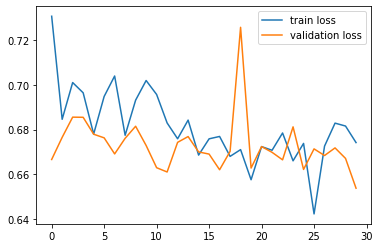

In [ ]:
plt.plot( hist.history['loss'], label='train loss')
plt.plot( hist.history['val_loss'], label='validation loss')
plt.legend()

### accuracy

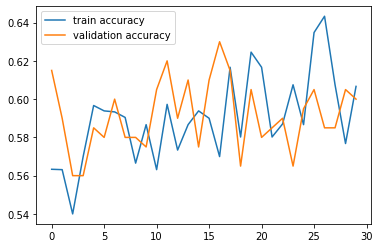

In [ ]:
plt.plot( hist.history['acc'], label='train accuracy')
plt.plot( hist.history['val_acc'], label='validation accuracy')
plt.legend()

## 웰시코기 학습 1 후기
- 앞으로 생성할 모델의 기준점이 될 첫 학습
- 로스와 정확도 모두 개선되는 모습을 보이지 않는다.
- 들쭉 날쭉한 모형으로 학습이 제대로 이루어지지 않는 것으로 보인다.
- 2차 이미지 수집 필요성을 느낌

# 웰시코기 2차 이미지 수집
- 합계 1241장
- SNS와 지인들의 반려견 이미지 수집
- 수기로 비만/정상 이미지 분류
- 정상 : 617장, 비만 : 624장 으로 균형있는 세트를 구성

# 웰시코기 학습 2

In [ ]:
base_dir = '/home/lab13/dog_pic/웰시코기/웰시코기_set_2'

# 학습 이미지 경로
nor_path = os.path.join(base_dir, '웰시코기_정상')
fat_path = os.path.join(base_dir, '웰시코기_비만')

nor_list = os.listdir(nor_path)
fat_list = os.listdir(fat_path)

print(len( nor_list ))
print(len( fat_list ))

617
624


In [ ]:
base_dir = '/home/lab13/dog_pic/웰시코기/웰시코기_set_2'

# # 훈련셋, 검증셋, 테스트셋을 미리 분할하기 위한 폴더 경로
train_path = os.path.join(base_dir, 'train')
# os.mkdir( train_path)/

val_path = os.path.join(base_dir, 'validation')
# os.mkdir( val_path)

test_path = os.path.join(base_dir, 'test')
# os.mkdir( test_path)


# # train 정상 폴더
train_nor_path = os.path.join(train_path, 'nor')
# os.mkdir( train_nor_path)

# # train 비만 폴더
train_fat_path = os.path.join(train_path, 'fat')
# os.mkdir( train_fat_path)

# # validation 정상 폴더
val_nor_path = os.path.join(val_path, 'nor')
# os.mkdir( val_nor_path)

# # validation 비만 폴더
val_fat_path = os.path.join(val_path, 'fat')
# os.mkdir( val_fat_path)

# # test 정상 폴더
test_nor_path = os.path.join(test_path, 'nor')
# os.mkdir( test_nor_path)

# # test 비만 폴더
test_fat_path = os.path.join(test_path, 'fat')
# os.mkdir( test_fat_path)

In [ ]:
print(f'train set : {len(os.listdir(train_nor_path)) + len(os.listdir(train_fat_path))}')
print(f'validation set : {len(os.listdir(val_nor_path)) + len(os.listdir(val_fat_path))}')
print(f'test set : {len(os.listdir(test_nor_path)) + len(os.listdir(test_fat_path))}')
print(f'total set : {len(nor_list) + len(fat_list)}')

train set : 620
validation set : 247
test set : 374
total set : 1241


## 이미지 전처리

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 데이터의 경로

base_dir = '/home/lab13/dog_pic/웰시코기/웰시코기_set_2'
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'validation')
test_path = os.path.join(base_dir, 'test')


# 모든 이미지의 픽셀값을 스케일링
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size = (300, 300),
  batch_size = 15,
  class_mode = 'binary'
)

val_generator = test_datagen.flow_from_directory(
  val_path,
  target_size = (300, 300),
  batch_size = 15,
  class_mode = 'binary'
)

Found 620 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


## 네트워크 구성

In [ ]:
model = tf.keras.models.Sequential()

# Convolution Layer
model.add( tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

# feature map -> input
model.add( tf.keras.layers.Flatten() )

# Neural Network
model.add( tf.keras.layers.Dense(512, activation='relu') ) # hidden layer
model.add( tf.keras.layers.Dense(1, activation='sigmoid') )# output layer

# optimaze
model.compile(
  loss = 'binary_crossentropy',
  metrics = ['acc'],
  optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)
)

2022-03-25 15:12:42.680037: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-25 15:12:42.681145: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-25 15:12:42.706577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 15:12:42.706920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-25 15:12:42.706944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-25 15:12:42.710176: I tensorflow/stream_executor/platform/default/dso_loade

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

## 학습 진행
- 학습 추세를 빠르게 알아보기 위해 epoch = 20으로 설정
- 늘어난 학습/검증 자료 수 만큼 steps 또한 증가

In [ ]:
hist = model.fit_generator(
  train_generator,
  steps_per_epoch = 40,
  epochs = 20,
  validation_data = val_generator,
  validation_steps= 15
)

2022-03-25 14:41:28.374492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-25 14:41:28.391864: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/20


2022-03-25 14:41:29.066299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-25 14:41:29.598871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-03-25 14:41:29.606008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


40/40 [==============================] - 13s 214ms/step - loss: 0.7373 - acc: 0.5116 - val_loss: 0.6829 - val_acc: 0.5333
Epoch 2/20
40/40 [==============================] - 7s 185ms/step - loss: 0.6673 - acc: 0.6168 - val_loss: 0.6212 - val_acc: 0.6578
Epoch 3/20
40/40 [==============================] - 7s 180ms/step - loss: 0.6114 - acc: 0.6798 - val_loss: 0.6093 - val_acc: 0.6622
Epoch 4/20
40/40 [==============================] - 7s 181ms/step - loss: 0.5421 - acc: 0.7127 - val_loss: 0.6009 - val_acc: 0.6711
Epoch 5/20
40/40 [==============================] - 7s 181ms/step - loss: 0.5308 - acc: 0.7366 - val_loss: 0.6301 - val_acc: 0.6756
Epoch 6/20
40/40 [==============================] - 7s 185ms/step - loss: 0.5226 - acc: 0.7380 - val_loss: 0.5960 - val_acc: 0.6889
Epoch 7/20
40/40 [==============================] - 7s 185ms/step - loss: 0.4456 - acc: 0.8203 - val_loss: 0.6071 - val_acc: 0.7111
Epoch 8/20
40/40 [==============================] - 7s 179ms/step - loss: 0.4275 - acc

### loss

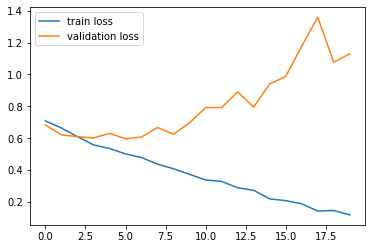

In [ ]:
plt.plot( hist.history['loss'], label='train loss')
plt.plot( hist.history['val_loss'], label='validation loss')
plt.legend()

### accuracy

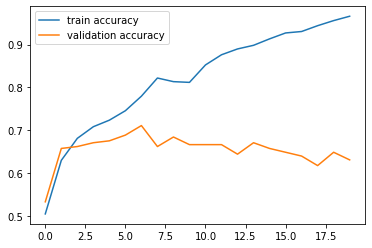

In [ ]:
plt.plot( hist.history['acc'], label='train accuracy')
plt.plot( hist.history['val_acc'], label='validation accuracy')
plt.legend()

## 웰시코기 학습 2 후기
- 과적합 발생
- 학습 3에서는 과적합을 줄일 수 있는 방법을 사용하자
    - DropOut
    - L1규제 , L2규제

# 웰시코기 학습 3
- 과적합을 제거하기 위해 DropOut층 추가

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 이미지 전처리
- 스케일링, 이미지 증식
- 이미지 크기 300 x 300
- batch_size = 30


In [ ]:
# 학습 이미지를 생성
train_datagen = ImageDataGenerator(
  rescale = 1./255,
  rotation_range = 40,
  width_shift_range= 0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

# 검증 이미지는 증식하지 않는다.
# 검증 데이터는 학습 과정에서 절대로 사용되어선 안된다.
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size = (300, 300), 
  batch_size = 15,
  class_mode = 'binary'
)

val_generator = test_datagen.flow_from_directory(
  val_path,
  target_size = (300, 300), 
  batch_size = 15,
  class_mode = 'binary'
)

Found 620 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


## 네트워크 구성 및 규제 추가
- Dense층에 입력하기 전에 Dropout층 추가

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
model = tf.keras.models.Sequential()

# Convolution Layer
model.add( tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

# feature map -> input
model.add( tf.keras.layers.Flatten() )

# DropOut Layer
model.add( tf.keras.layers.Dropout(0.5) )

# Neural Network
model.add( tf.keras.layers.Dense(512, activation='relu') ) # hidden layer
# Neural Network
model.add( tf.keras.layers.Dense(1, activation='sigmoid') )# output layer


# optimaze
model.compile(
  loss = 'binary_crossentropy',
  metrics = ['acc'],
  optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)
)

2022-03-25 23:08:26.137192: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-25 23:08:26.138212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-25 23:08:26.195148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 23:08:26.195744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-25 23:08:26.195768: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-25 23:08:26.198713: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
hist = model.fit_generator(
  train_generator,
  steps_per_epoch = 40,
  epochs = 4000,
  validation_data = val_generator,
  validation_steps= 15
)

2022-03-25 23:08:41.351709: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-25 23:08:41.371119: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/4000


2022-03-25 23:08:42.064124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-25 23:08:42.616554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-03-25 23:08:42.623878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


40/40 [==============================] - 21s 428ms/step - loss: 0.7188 - acc: 0.4875 - val_loss: 0.6813 - val_acc: 0.6311
Epoch 2/4000
40/40 [==============================] - 16s 412ms/step - loss: 0.6835 - acc: 0.5594 - val_loss: 0.6239 - val_acc: 0.6578
Epoch 3/4000
40/40 [==============================] - 16s 410ms/step - loss: 0.6730 - acc: 0.5893 - val_loss: 0.6273 - val_acc: 0.6578
Epoch 4/4000
40/40 [==============================] - 17s 417ms/step - loss: 0.6378 - acc: 0.6416 - val_loss: 0.6031 - val_acc: 0.6667
Epoch 5/4000
40/40 [==============================] - 16s 408ms/step - loss: 0.6308 - acc: 0.6314 - val_loss: 0.6122 - val_acc: 0.6578
Epoch 6/4000
40/40 [==============================] - 17s 417ms/step - loss: 0.6474 - acc: 0.6060 - val_loss: 0.6436 - val_acc: 0.6533
Epoch 7/4000
40/40 [==============================] - 16s 411ms/step - loss: 0.6020 - acc: 0.6681 - val_loss: 0.5921 - val_acc: 0.6756
Epoch 8/4000
40/40 [==============================] - 17s 413ms/step

KeyboardInterrupt: 

## 웰시코기 학습 3 후기
- DropOut층을 다양하게 추가하기 vs L1 or L2규제 사용하기
    - 다른 규제를 사용해보자
    - 학습 4는 L2 규제를 2번 추가해본다

# 웰시코기 학습 4

## 이미지 전처리
- 스케일링 이미지 증식
- 이미지 크기 300 x 300
- batch_size = 10
- 과적합 방지
    - DropOut + L2 규제 2회

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 학습 이미지를 생성
train_datagen = ImageDataGenerator(
  rescale = 1./255,
  rotation_range = 40,
  width_shift_range= 0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

# 검증 이미지는 증식하지 않는다.
# 검증 데이터는 학습 과정에서 절대로 사용되어선 안된다.
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size = (300, 300), 
  batch_size = 10,
  class_mode = 'binary'
)

val_generator = test_datagen.flow_from_directory(
  val_path,
  target_size = (300, 300), 
  batch_size = 10,
  class_mode = 'binary'
)

Found 620 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


## 네트워크 구성 및 규제 추가
- DropOut과 L2규제 2회 추가

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
model = tf.keras.models.Sequential()

# Convolution Layer
model.add( tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

model.add( tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add( tf.keras.layers.MaxPool2D((2,2)))

# feature map -> input
model.add( tf.keras.layers.Flatten() )

# DropOut Layer
model.add( tf.keras.layers.Dropout(0.5) )

# Neural Network
model.add( tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(0.001),
                                 activation='relu') ) # hidden layer
# Neural Network
model.add( tf.keras.layers.Dense(1, kernel_regularizer = regularizers.l2(0.001),
                                 activation='sigmoid') )# output layer


# optimaze
model.compile(
  loss = 'binary_crossentropy',
  metrics = ['acc'],
  optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)
)

2022-03-26 10:44:24.398147: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-26 10:44:24.399190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-26 10:44:24.458892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 10:44:24.459515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-26 10:44:24.459544: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-26 10:44:24.462535: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
hist = model.fit_generator(
  train_generator,
  steps_per_epoch = 40,
  epochs = 3000,
  validation_data = val_generator,
  validation_steps= 15
)

2022-03-26 10:44:32.094198: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-26 10:44:32.111106: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/3000


2022-03-26 10:44:32.882673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-26 10:44:33.419243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-03-26 10:44:33.425027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


40/40 [==============================] - 15s 286ms/step - loss: 1.1653 - acc: 0.4672 - val_loss: 0.9884 - val_acc: 0.5800
Epoch 2/3000
40/40 [==============================] - 11s 277ms/step - loss: 0.9571 - acc: 0.5365 - val_loss: 0.8686 - val_acc: 0.6400
Epoch 3/3000
40/40 [==============================] - 11s 275ms/step - loss: 0.8514 - acc: 0.5843 - val_loss: 0.7970 - val_acc: 0.5800
Epoch 4/3000
40/40 [==============================] - 11s 280ms/step - loss: 0.7737 - acc: 0.6213 - val_loss: 0.7554 - val_acc: 0.6000
Epoch 5/3000
40/40 [==============================] - 11s 276ms/step - loss: 0.7602 - acc: 0.6253 - val_loss: 0.6944 - val_acc: 0.6600
Epoch 6/3000
40/40 [==============================] - 11s 275ms/step - loss: 0.7399 - acc: 0.5878 - val_loss: 0.6840 - val_acc: 0.6267
Epoch 7/3000
40/40 [==============================] - 11s 280ms/step - loss: 0.6879 - acc: 0.6582 - val_loss: 0.6251 - val_acc: 0.7467
Epoch 8/3000
40/40 [==============================] - 11s 277ms/step

## 웰시코기 학습 4 후기
- 과적합을 막지 못했다.

# CNN 학습 후기
- 우선 성능이 매우 떨어진다.
- 성능을 개선하기 위해 이미지 증식을 활용했지만, 과적합을 피할 수 없었다.
    - 과적합을 제거하기 위한 노력
        - DropOut 층 추가
        - DropOut + L2 규제 2회 추가
- 이미지 세트 자체가 문제일 수도 있다.
- 멘토님께 다양한 이미지 전처리를 시도하도록 지도 받음
    - https://lsjsj92.tistory.com/355
    - https://kcy51156.tistory.com/55
    - https://ivo-lee.tistory.com/91
    - https://lsjsj92.tistory.com/355
- 다양한 이미지 분석 딥러닝 알고리즘 활용하도록 지도 받음
    - pytorch 사용해보자!
        - https://ybworld.tistory.com/130
        - https://ybworld.tistory.com/129

# 아쉬운 점
- CNN의 신경망을 더 깊게 탐구하지 못한 것이 아쉽다.

# 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
sets = ['CNN set 1', 'CNN set 2', 'Pth set 1', 'Pth set 2', 'Pth set 3',
        'Pth set 4', 'Pth set 5', 'Pth set 6', 'Pth set 7', 'Pth set 8'
       , 'Pth set 9']
loss = [0.67, 1.20, 1.01, 1.15, 0.51, 1.16, 0.65, 0.64, 0.61, 0.90, 0.60]
acc = [0.6, 0.6, 0.7471, 0.7816, 0.8554, 0.7730, 0.8500, 0.8431, 0.8338, 0.8062, 0.8923]

In [ ]:
sets = np.array(sets)
loss = np.array(loss)
acc = np.array(acc)

In [ ]:
df = pd.DataFrame({'Sets' : sets,
                  'loss' : loss,
                  'acc' : acc})
df

,Sets,loss,acc
0,CNN set 1,0.67,0.6000
1,CNN set 2,1.20,0.6000
2,Pth set 1,1.01,0.7471
3,Pth set 2,1.15,0.7816
4,Pth set 3,0.51,0.8554
5,Pth set 4,1.16,0.7730
6,Pth set 5,0.65,0.8500
7,Pth set 6,0.64,0.8431
8,Pth set 7,0.61,0.8338
9,Pth set 8,0.90,0.8062


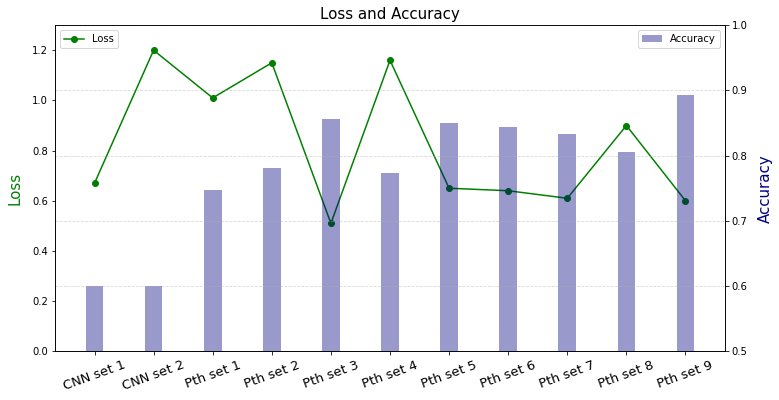

In [ ]:
# loss / acc
plt.figure(figsize=(12,6))

plt.plot( df['loss'], color='green', linewidth=1.5, marker='o', label='Loss')
plt.ylabel('Loss', color='green', labelpad = 10, fontsize=15)
# plt.xlabel('Image Set', fontsize=15)
plt.xticks( rotation = 20, fontsize=13)
plt.ylim(0.0, 1.3)
plt.legend(loc = 'upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.bar(df.Sets, df['acc'],alpha=0.4 ,width=0.3, color='navy' , label = 'Accuracy' )
ax2.set_ylabel('Accuracy', color='navy' , labelpad = 10 , fontsize=15)
plt.ylim(0.5, 1.0)
plt.legend(loc = 'upper right')

plt.title('Loss and Accuracy', fontsize=15)
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

In [ ]:
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5',
        'set 6', 'set 7', 'set 8']
loss = [0.2604, 0.2335, 0.3674, 0.4679, 0.1917, 0.6369, 0.4263, 0.4204]
acc = [0.9187, 0.9228,  0.9024, 0.9187, 0.9430, 0.8171, 0.8720, 0.8964]

sets = np.array(sets)
loss = np.array(loss)
acc = np.array(acc)

df = pd.DataFrame({'set' : sets,
                  'loss' : loss,
                  'acc' : acc})
df

,set,loss,acc
0,set 1,0.2604,0.9187
1,set 2,0.2335,0.9228
2,set 3,0.3674,0.9024
3,set 4,0.4679,0.9187
4,set 5,0.1917,0.9430
5,set 6,0.6369,0.8171
6,set 7,0.4263,0.8720
7,set 8,0.4204,0.8964


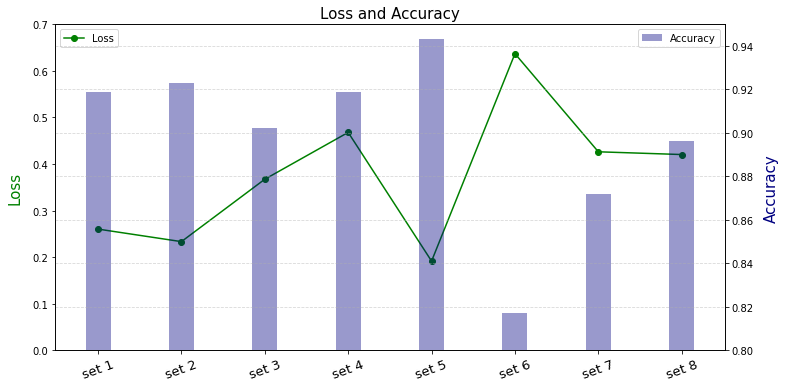

In [ ]:
# loss / acc
plt.figure(figsize=(12,6))

plt.plot( df['loss'], color='green', linewidth=1.5, marker='o', label='Loss')
plt.ylabel('Loss', color='green', labelpad = 10, fontsize=15)
# plt.xlabel('Image Set', fontsize=15)
plt.xticks( rotation = 20, fontsize=13)
plt.ylim(0.0, 0.7)
plt.legend(loc = 'upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.bar(df.set, df['acc'],alpha=0.4 ,width=0.3, color='navy' , label = 'Accuracy' )
ax2.set_ylabel('Accuracy', color='navy' , labelpad = 10 , fontsize=15)
plt.ylim(0.8, 0.95)
plt.legend(loc = 'upper right')

plt.title('Loss and Accuracy', fontsize=15)
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

In [ ]:
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5',
        'set 6', 'set 7', 'set 8']
loss = [0.5013, 0.5006, 0.6272, 0.9832, 0.1888, 0.2433, 0.4016, 0.3315]
acc  = [0.8000, 0.7560, 0.8040, 0.7000, 0.9480, 0.9440, 0.8760, 0.8951]

sets = np.array(sets)
loss = np.array(loss)
acc = np.array(acc)

df = pd.DataFrame({'set' : sets,
                  'loss' : loss,
                  'acc' : acc})
df

,set,loss,acc
0,set 1,0.5013,0.8000
1,set 2,0.5006,0.7560
2,set 3,0.6272,0.8040
3,set 4,0.9832,0.7000
4,set 5,0.1888,0.9480
5,set 6,0.2433,0.9440
6,set 7,0.4016,0.8760
7,set 8,0.3315,0.8951


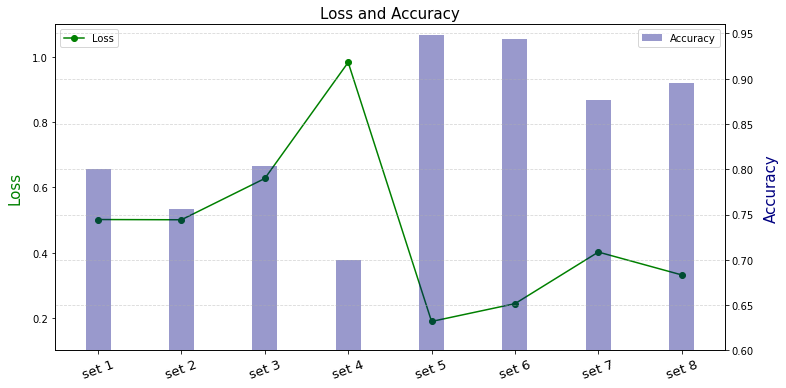

In [ ]:
# loss / acc
plt.figure(figsize=(12,6))

plt.plot( df['loss'], color='green', linewidth=1.5, marker='o', label='Loss')
plt.ylabel('Loss', color='green', labelpad = 10, fontsize=15)
# plt.xlabel('Image Set', fontsize=15)
plt.xticks( rotation = 20, fontsize=13)
plt.ylim(0.1, 1.1)
plt.legend(loc = 'upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.bar(df.set, df['acc'],alpha=0.4 ,width=0.3, color='navy' , label = 'Accuracy' )
ax2.set_ylabel('Accuracy', color='navy' , labelpad = 10 , fontsize=15)
plt.ylim(0.6, 0.96)
plt.legend(loc = 'upper right')

plt.title('Loss and Accuracy', fontsize=15)
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()